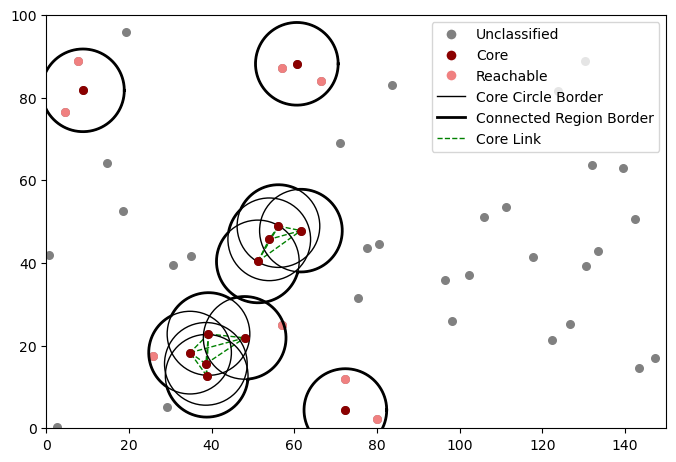

In [65]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from shapely.geometry import Point
from shapely.ops import unary_union

# -----------------------------
# Algorithm parameters
# -----------------------------
ALG_PARAMS = {
    "n_points": 50,
    "canvas_width": 150,
    "canvas_height": 100,
    "scan_radius": 10,
    "min_points": 3,
}

# -----------------------------
# Visual style parameters
# -----------------------------
POINT_STYLE = {
    "size": 30,
    "core_color": "darkred",
    "reachable_color": "lightcoral",
    "unclassified_color": "gray",
}

CIRCLE_STYLE = {
    "border_color": "black",
    "border_width": 1.0,
}

LINK_STYLE = {
    "color": "green",
    "width": 1.0,
    "linestyle": "--",
}

REGION_STYLE = {
    "color": "black",
    "width": 2,
}

# -----------------------------
# Core computation functions
# -----------------------------


def find_core_points(points, scan_radius, min_points):
    """Identify core points and points inside each core circle."""
    core_indices = []
    points_in_circle = []
    for i, p in enumerate(points):
        neighbors = np.where(np.linalg.norm(points - p, axis=1) <= scan_radius)[0]
        if len(neighbors) >= min_points:
            core_indices.append(i)
            points_in_circle.append(set(neighbors))
        else:
            points_in_circle.append(set([i]))
    return points[core_indices], core_indices, points_in_circle


def build_core_graph(core_indices, points_in_circle):
    """Build undirected graph connecting overlapping core circles."""
    G = nx.Graph()
    for idx in range(len(core_indices)):
        G.add_node(idx)
    for i, ci in enumerate(core_indices):
        for j, cj in enumerate(core_indices):
            if i >= j:
                continue
            if len(points_in_circle[ci] & points_in_circle[cj]) > 0:
                G.add_edge(i, j)
    return G


# -----------------------------
# Plotting functions
# -----------------------------


def plot_all_points(ax, points, core_indices):
    """Plot all points and highlight core points."""
    ax.scatter(
        points[:, 0],
        points[:, 1],
        s=POINT_STYLE["size"],
        color=POINT_STYLE["unclassified_color"],
        zorder=1,
    )
    ax.scatter(
        points[core_indices, 0],
        points[core_indices, 1],
        s=POINT_STYLE["size"],
        color=POINT_STYLE["core_color"],
        zorder=4,
    )


def plot_core_circles(ax, core_points, scan_radius):
    """Plot core circles around core points (no fill)."""
    for p in core_points:
        ax.add_patch(
            Circle(
                p,
                scan_radius,
                fill=False,
                edgecolor=CIRCLE_STYLE["border_color"],
                linewidth=CIRCLE_STYLE["border_width"],
                zorder=3,
            )
        )


def plot_core_links(ax, G, core_points):
    """Plot dashed lines connecting overlapping core points."""
    for i, j in G.edges():
        p1, p2 = core_points[i], core_points[j]
        ax.plot(
            [p1[0], p2[0]],
            [p1[1], p2[1]],
            color=LINK_STYLE["color"],
            linewidth=LINK_STYLE["width"],
            linestyle=LINK_STYLE["linestyle"],
            zorder=2,
        )


def plot_connected_regions(ax, G, core_points, scan_radius):
    """Draw borders around connected regions of core circles."""
    for component in nx.connected_components(G):
        circles = [
            Point(core_points[i]).buffer(scan_radius, resolution=64) for i in component
        ]
        union_shape = unary_union(circles)
        polygons = (
            [union_shape]
            if union_shape.geom_type == "Polygon"
            else list(union_shape.geoms)
        )
        for poly in polygons:
            x, y = poly.exterior.xy
            ax.plot(
                x,
                y,
                color=REGION_STYLE["color"],
                linewidth=REGION_STYLE["width"],
                zorder=6,
            )


def plot_reachable_points(ax, points, core_indices, G, core_points, scan_radius):
    """Mark points reachable from any connected core region."""
    for component in nx.connected_components(G):
        circles = [
            Point(core_points[i]).buffer(scan_radius, resolution=64) for i in component
        ]
        union_shape = unary_union(circles)
        for i, p in enumerate(points):
            if i not in core_indices and union_shape.contains(Point(p)):
                ax.scatter(
                    p[0],
                    p[1],
                    s=POINT_STYLE["size"],
                    color=POINT_STYLE["reachable_color"],
                    zorder=4,
                )


def plot_legend(ax):
    """Add a legend showing point types, core circles, connected regions, and links."""
    elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Unclassified",
            markerfacecolor=POINT_STYLE["unclassified_color"],
            markersize=8,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Core",
            markerfacecolor=POINT_STYLE["core_color"],
            markersize=8,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Reachable",
            markerfacecolor=POINT_STYLE["reachable_color"],
            markersize=8,
        ),
        Line2D(
            [0],
            [0],
            color=CIRCLE_STYLE["border_color"],
            lw=CIRCLE_STYLE["border_width"],
            label="Core Circle Border",
        ),
        Line2D(
            [0],
            [0],
            color=REGION_STYLE["color"],
            lw=REGION_STYLE["width"],
            label="Connected Region Border",
        ),
        Line2D(
            [0],
            [0],
            color=LINK_STYLE["color"],
            lw=LINK_STYLE["width"],
            linestyle=LINK_STYLE["linestyle"],
            label="Core Link",
        ),
    ]
    ax.legend(handles=elements, loc="upper right")


# -----------------------------
# Main workflow
# -----------------------------
points = np.column_stack(
    (
        np.random.rand(ALG_PARAMS["n_points"]) * ALG_PARAMS["canvas_width"],
        np.random.rand(ALG_PARAMS["n_points"]) * ALG_PARAMS["canvas_height"],
    )
)

core_points, core_indices, points_in_circle = find_core_points(
    points, ALG_PARAMS["scan_radius"], ALG_PARAMS["min_points"]
)
G = build_core_graph(core_indices, points_in_circle)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, ALG_PARAMS["canvas_width"])
ax.set_ylim(0, ALG_PARAMS["canvas_height"])
ax.set_aspect("equal")

plot_all_points(ax, points, core_indices)
plot_core_circles(ax, core_points, ALG_PARAMS["scan_radius"])
plot_connected_regions(ax, G, core_points, ALG_PARAMS["scan_radius"])
plot_core_links(ax, G, core_points)
plot_reachable_points(
    ax, points, core_indices, G, core_points, ALG_PARAMS["scan_radius"]
)
plot_legend(ax)

plt.show()